In [ ]:
# -*- coding: utf-8 -*-
from keras.models import Model
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, UpSampling2D, Dropout, Input, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as K

# 参数

In [ ]:
mosaic_size = 256
unet_model_path = "test256/u-net-model.yaml"
unet_weight_path = 'test256/unet_best_checkpoint.hdf5'
unet_weight_checkpoint_path = 'test256/unet_best_checkpoint.hdf5'
batch_size = 15
epochs = 100
tensorboard_log_directory = "/root/notebooks/tensorflow_logs"
load_weigth = True
learning_rate = 1e-5
fit_verbose = True

# Jaccard损失函数

In [ ]:
def jaccard_coefficient(output, target, axis=[1,2,3], smooth=1e-5):
    """Jaccard coefficient for comparing the similarity of two
    batch of data, usually be used for binary image segmentation.
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.

    Parameters
    -----------
    output : tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    axis : list of integer
        All dimensions are reduced, default ``[1,2,3]``.
    smooth : float
        This small value will be added to the numerator and denominator.
        If both output and target are empty, it makes sure dice is 1.
        If either output or target are empty (all pixels are background), dice = ```smooth/(small_value + smooth)``,
        then if smooth is very small, dice close to 0 (even the image values lower than the threshold),
        so in this case, higher smooth can have a higher dice.
        
    Examples
    ---------
    >>> a = tf.constant([[[[1],[0]],[[1],[1]]]],dtype=tf.float64)
    >>> b = tf.constant([[[[1],[1]],[[1],[1]]]],dtype=tf.float64)
    >>> val = jaccard_coefficient(a,b)
    >>> session = tf.Session()
    >>> session.run(val)

    References
    -----------
    - `Jaccard coefficient <https://en.wikipedia.org/wiki/Jaccard_index>`_
    """
    inse = K.sum(output * target, axis=axis)
    l = K.sum(output * output, axis=axis)
    r = K.sum(target * target, axis=axis)
    dice = (2. * inse + smooth) / (l + r + smooth)
    return K.mean(dice)

# 定义网络结构

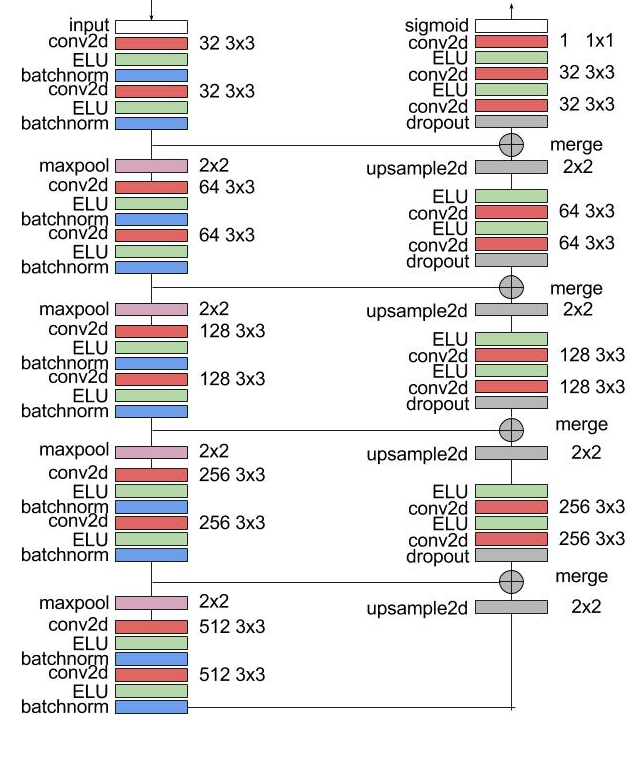

In [1]:
from IPython.display import Image
Image(filename="unet-5.png")

In [ ]:
def get_unet(size):
    inputs = Input(shape=(size, size, 3))
    
# left
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    
    pool1 = MaxPool2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    
    pool2 = MaxPool2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    
    pool3 = MaxPool2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    
    pool4 = MaxPool2D(pool_size=(2, 2))(conv4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

# right
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    up6 = Dropout(0.2)(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    up7 = Dropout(0.2)(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    up8 = Dropout(0.2)(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    up9 = Dropout(0.2)(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=[jaccard_coefficient])
    
    return model

In [ ]:
def train_net(x_train, y_train, x_val, y_val, load_weigth=load_weigth):
    print(u"开始训练网络")
    
    model = get_unet(mosaic_size)
    
    with open(unet_model_path, "w+") as mf:
        mf.write(model.to_yaml())
    if load_weigth:
        model.load_weights(unet_weight_path)
    
    model_checkpoint = ModelCheckpoint(unet_weight_checkpoint_path, monitor='loss', save_best_only=True, verbose=0)
    
    tensorboard = TensorBoard(log_dir=tensorboard_log_directory, write_graph=True, write_images=True)
    
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=fit_verbose, shuffle=True,
              callbacks=[model_checkpoint, tensorboard], validation_data=(x_val, y_val))
    
    return model

# 训练

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
x_data = np.load("x_data.npy")
y_data = np.load("y_data.npy")

In [ ]:
index = []
for idx, data in enumerate(y_data):
    if not np.all(data==0):
        index.append(idx)
y_data = y_data.reshape(y_data.shape[0], y_data.shape[1], y_data.shape[2], 1)
x_train, x_test, y_train, y_test = train_test_split(x_data[index], y_data[index], test_size=0.2, random_state=42)

In [ ]:
trained_model = train_net(x_train, y_train, x_test, y_test)